In [250]:
#import modules
#standard libraries
import numpy as np
import itertools

#learning and evalution modules
import torch
from hmmlearn import hmm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

#signal analysis
from scipy import signal
from scipy.io import wavfile
import librosa

#plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


### Objects in Dataset
We first show all the objects in the dataset. Visually we recognize that some of these objects have a similar texture and so classification using contact microphone data may not *always* work.

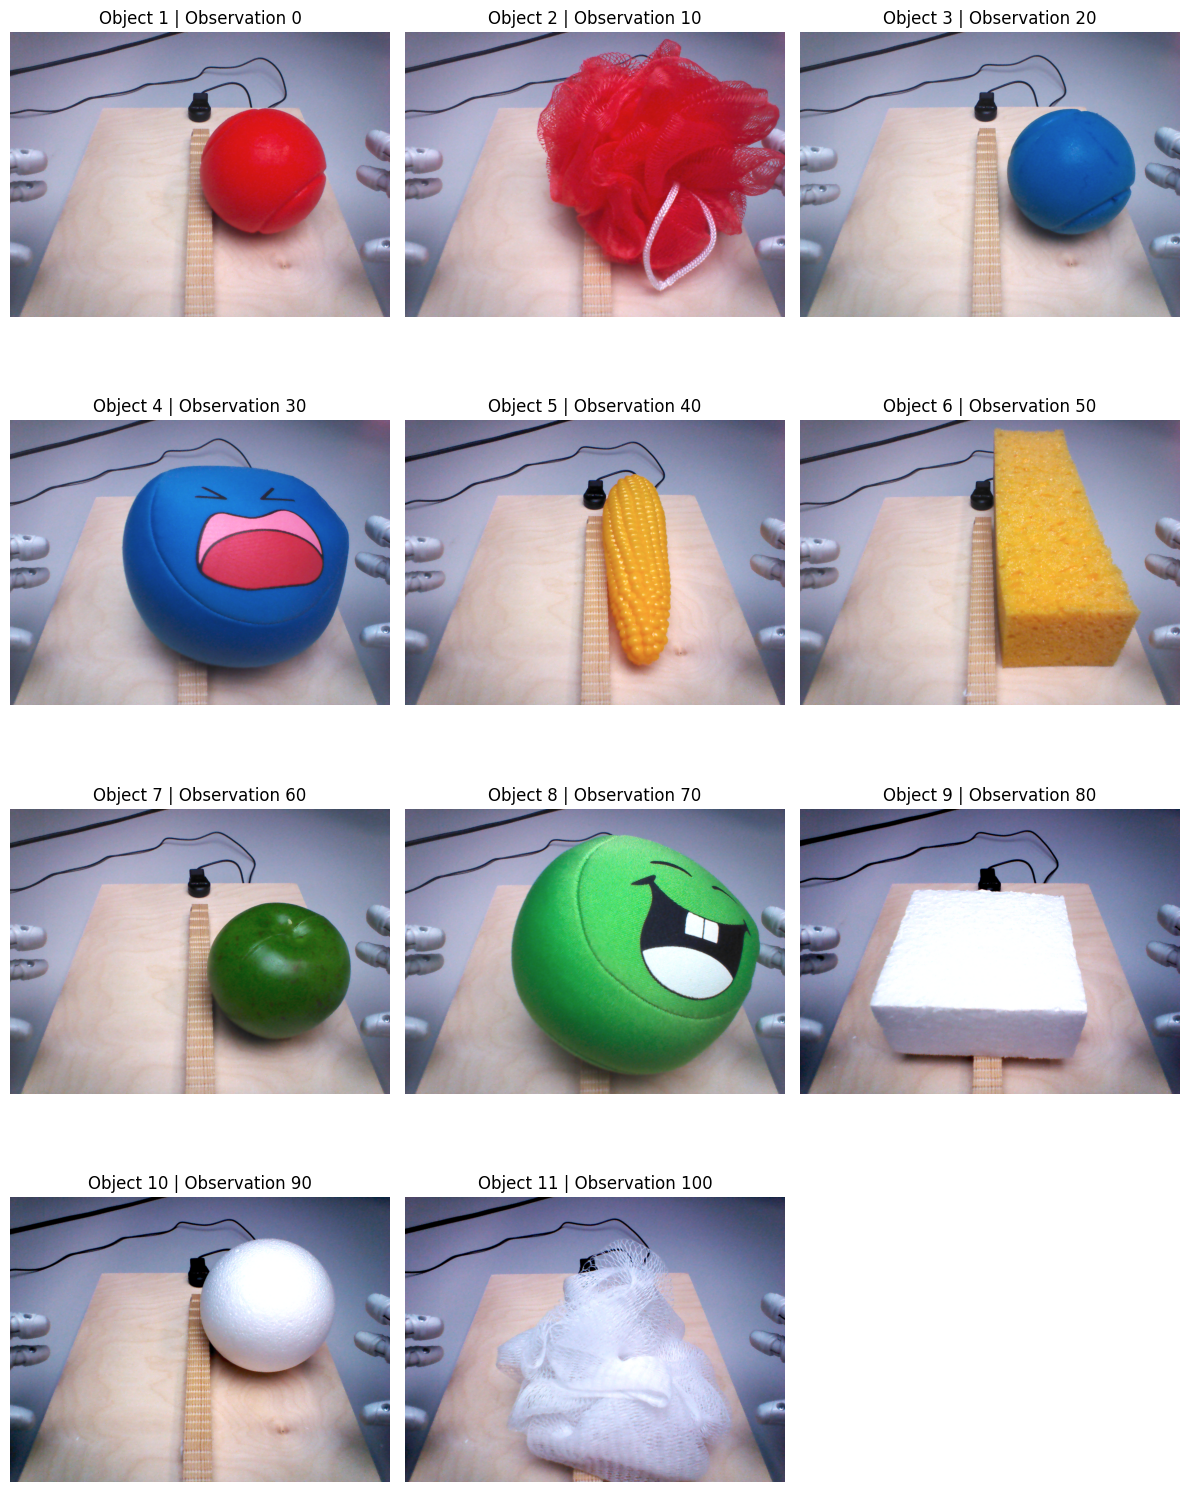

In [5]:
num_rows = 4
num_cols = 3
total_images = num_rows * num_cols
objects = 11

#create a figure and a set of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 16))  # Adjust figsize accordingly

#initialize a counter for the image index
idx = 0

#iterate through the subdirectories
for object_num in range(1, objects + 1):
    run_ideal_num = 0
    run_ideal_num += 10 * (object_num - 1)
    image_path = f'../Toprak_Dataset/raw-data/ideal/object_{object_num}/observation_{run_ideal_num}/foreground.png'
    img = mpimg.imread(image_path)
    i, j = divmod(idx, num_cols)
    axes[i, j].imshow(img)
    axes[i, j].set_title(f'Object {object_num} | Observation {run_ideal_num}')
    axes[i, j].axis('off')
    idx += 1

fig.delaxes(axes[-1, -1])
plt.tight_layout()
plt.show()

### Data Processing
Several processing steps are usually performed on time-series data. These include:
- De-noising by spectral noise subtraction
- Data normalization to mean of zero and standard deviation of one

In [220]:
#functions for:
    #FFT calculations with windowing
    #noise spectrum estimation/subtraction
    #data normalization

#noise spectrum estimation/subtraction adapted from: 
    #https://abhipray.com/posts/sigproc/classic_speech_enhancement/spectral_subtraction/

def signal_to_frames(y: np.array, m, hop_size, fs):
    #time-series -> FFT -> Y[m]   
    _, _, Y = signal.stft(y, fs=fs, nperseg=m, noverlap=hop_size, nfft=m*8)

    return Y.T

def frames_to_signal(Y: np.array, m, hop_size, fs):
    #Y[m] -> IFFT -> time-series
    _, y = signal.istft(Y.T, fs=fs, nperseg=m, noverlap=hop_size, nfft=m*8)

    return y

def noise_spectrum_estimator(Y: np.array, N):
    Dm = np.zeros(Y.shape) #noise estimate (magnitude: m)
    Dp = np.zeros(Y.shape) #noise estimate (power: p)
    a = 25 #scaling parameter for SNR estimation

    for m in range(Y.shape[0]):
        if m < N:
            #first N windows contain noise only
            Dm[m] = abs(Y[m])
            Dp[m] = Dm[m] ** 2
        else:
            #m-N windows contained noise + signal
            aSNR = (abs(Y[m]) ** 2)/np.mean(abs(Y[m-N:m]) ** 2, axis=0) #a-posteriori SNR
            alpha = 1/(1 + np.exp(-a * (aSNR - 1.5)))
            Dm[m] = alpha * abs(est_Mn[m - 1]) + (1 - alpha) * abs(Y[m])
            Dp[m] = alpha * (abs(est_Mn[m - 1]) ** 2) + (1 - alpha)*(abs(Y[m]) ** 2)

    return Dp

def noise_subtraction(Y: np.array, Dp: np.array) -> np.array:
    Xm = np.maximum(abs(Y) ** 2 - Dp, 0) #magnitude of the de-noised signal
    Xp = np.angle(Y) #phase of the de-noised signal
    X = np.sqrt(Xm) * np.exp(1j * Xp)

    return X

def audio_normalization(y: np.array):
    ys = np.zeros(y.shape)
    m = np.mean(y)
    std = np.std(y)
    ys = (y - m) / std

    return ys

def audio_extraction(file_path, channel, scaling=False):
    sampling_freq, audio = wavfile.read(file_path)
    audio = np.array(audio[:, channel])
    audio = audio.astype(np.float64)

    if scaling == True:
        audio = audio_normalization(audio)

    return sampling_freq, audio

### Inital Analysis of Data
We first analyze the data to see if there are visually perceptible difference in the audio for each object. To do this we compare the raw audio, Mel spectrograms and the Mel frequency cepstral coefficients (MFCCs) for the audio acquired for a given experiment on each object.

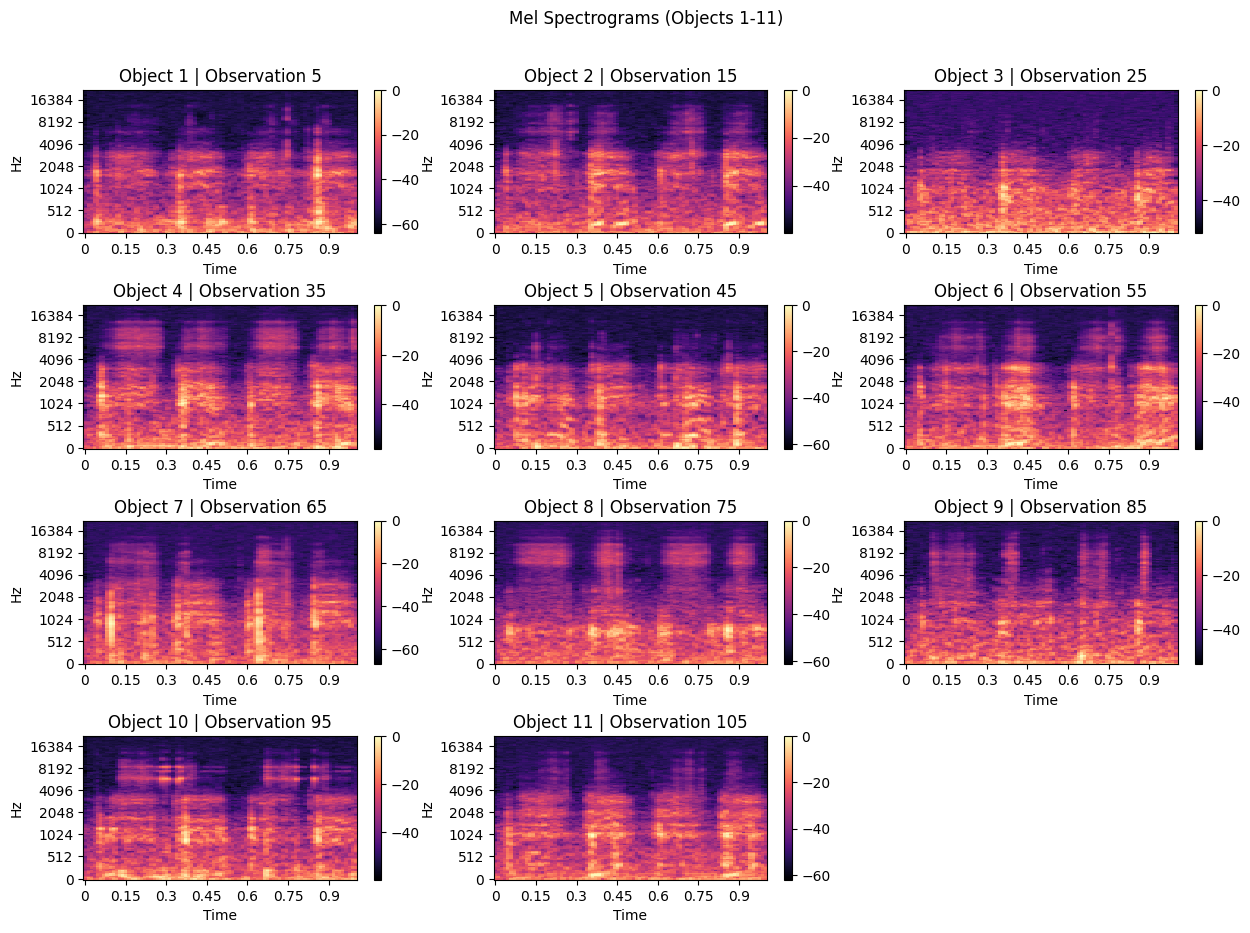

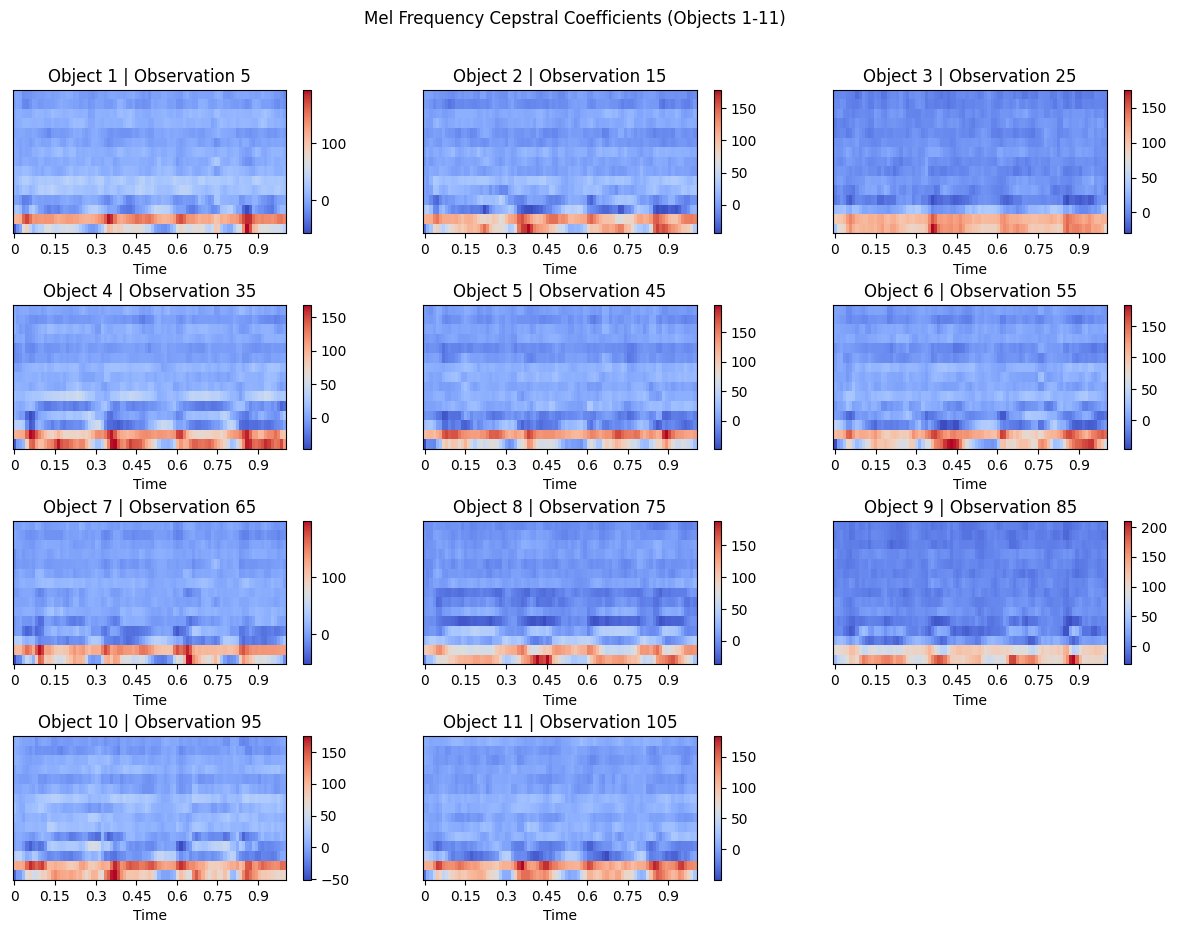

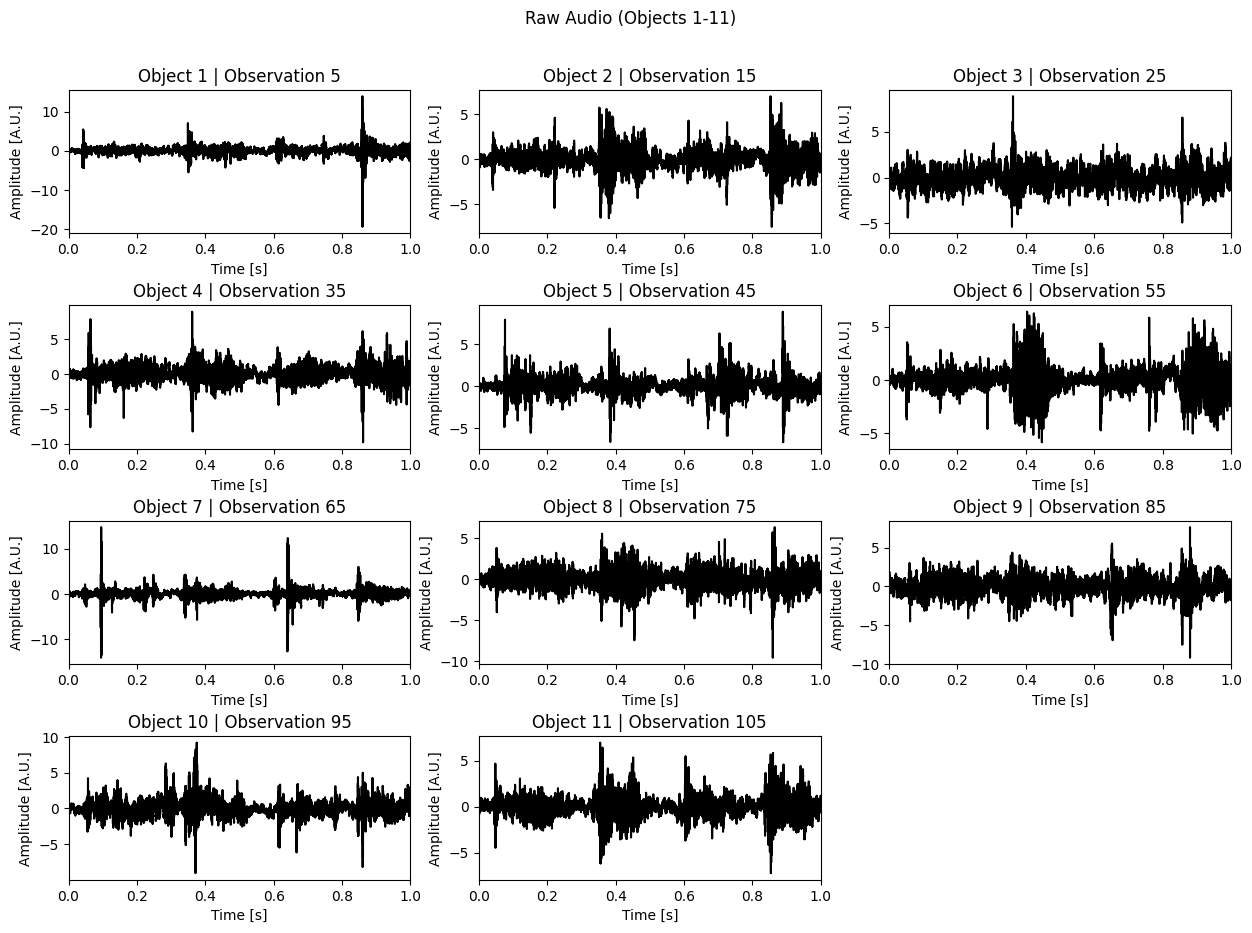

In [221]:
#dataset source: https://figshare.com/articles/dataset/Supplementary_Material_for_Evaluating_Integration_Strategies_for_Visuo-Haptic_Object_Recognition_/5280949
channel = 0            #channel to read data from
objects = 11           #total number of objects in the dataset

num_rows = 4
num_cols = 3

fig_1, axes_1 = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))
fig_2, axes_2 = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))
fig_3, axes_3 = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))

fig_1.suptitle('Mel Spectrograms (Objects 1-11)')
fig_2.suptitle('Mel Frequency Cepstral Coefficients (Objects 1-11)')
fig_3.suptitle('Raw Audio (Objects 1-11)')

for object_num in range(1, min(objects, num_rows * num_cols) + 1):
    run_ideal_num = 5  #only plot the data from the first run
    run_ideal_num += 10 * (object_num - 1)
    file_path = f'../Toprak_Dataset/raw-data/ideal/object_{object_num}/observation_{run_ideal_num}/haptic_texture/clean_signal.wav'
    sampling_freq, audio = audio_extraction(file_path, channel, scaling=True)

    mfcc_features = librosa.feature.mfcc(y=audio, sr=sampling_freq, n_mfcc=15)
    S = librosa.feature.melspectrogram(y=audio, sr=sampling_freq, n_mels=128)

    #calculate the row and column indices for the subplot
    row = (object_num - 1) // num_cols
    col = (object_num - 1) % num_cols

    #plot Mel spectrogram
    img1 = librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sampling_freq, x_axis='time', y_axis='mel', ax=axes_1[row, col])
    fig_1.colorbar(img1, ax=axes_1[row, col])
    axes_1[row, col].set_title(f'Object {object_num} | Observation {run_ideal_num}')

    #plot the MFCC
    img2 = librosa.display.specshow(mfcc_features, sr=sampling_freq, x_axis='time', ax=axes_2[row, col])
    fig_2.colorbar(img2, ax=axes_2[row, col])
    axes_2[row, col].set_title(f'Object {object_num} | Observation {run_ideal_num}')

    #plot the raw audio
    time = np.arange(len(audio)) / sampling_freq
    axes_3[row, col].plot(time, audio, '-k')
    axes_3[row, col].set_xlabel('Time [s]')
    axes_3[row, col].set_ylabel('Amplitude [A.U.]')
    axes_3[row, col].set_title(f'Object {object_num} | Observation {run_ideal_num}')
    axes_3[row, col].set_xlim([0,1])

#remove the empty subplot
fig_1.delaxes(axes_1[-1, -1])
fig_2.delaxes(axes_2[-1, -1])
fig_3.delaxes(axes_3[-1, -1])

# Adjust layout to prevent overlapping
fig_1.subplots_adjust(hspace=0.5, top=0.9)
fig_2.subplots_adjust(hspace=0.5, top=0.9)
fig_3.subplots_adjust(hspace=0.5, top=0.9)

In [279]:
#dataset source: https://figshare.com/articles/dataset/Supplementary_Material_for_Evaluating_Integration_Strategies_for_Visuo-Haptic_Object_Recognition_/5280949
#training: extract data from ideal/real folders and convert to MFCC observation
channel =               0               #microphone channel
objects =               11              #number of objects in dataset
run_ideal_total =       10              #total number of ideal runs
run_real_total =        3               #total number of real runs
run_ideal_max =         8               #number of ideal runs for training                 
run_real_max =          1               #number of real runs for training
mfcc_feature_max =      25              #number of MFCC features to consider
train_data =            np.array([])    #empty array for all training data
test_data =             np.array([])    #empty array for all testing data
object_data =           np.array([])    #empty array for each object's training data
train_lengths =         []              #length of each series of observations (training datset)
test_lengths =          []              #length of each series of observations (testing dataset
scaling =               True            #flag for normalization

for object_num in range(1, objects + 1):
    temp_train_lengths = []
    for run_ideal_num in range(0, run_ideal_max):
        run_ideal_num += 10*(object_num - 1)
        file_path = f'../Toprak_Dataset/raw-data/ideal/object_{object_num}/observation_{run_ideal_num}/haptic_texture/clean_signal.wav'
        sampling_freq, audio = audio_extraction(file_path, channel, scaling=scaling)
        mfcc_features = librosa.feature.mfcc(y=audio, sr=sampling_freq, n_mfcc=mfcc_feature_max)

        temp_train_lengths.append(np.transpose(mfcc_features).shape[0])

        if run_ideal_num == 10*(object_num - 1):
            object_data = np.transpose(mfcc_features)
        else:
            object_data = np.append(object_data, np.transpose(mfcc_features), axis=0)
            
    for run_real_num in range(0, run_real_max):
        run_real_num += 3*(object_num - 1)
        file_path = f'../Toprak_Dataset/raw-data/real/object_{object_num}/observation_{run_real_num}/haptic_texture/clean_signal.wav'
        sampling_freq, audio = audio_extraction(file_path, channel, scaling=scaling)
        mfcc_features = librosa.feature.mfcc(y=audio, sr=sampling_freq, n_mfcc=mfcc_feature_max)

        temp_train_lengths.append(np.transpose(mfcc_features).shape[0])

        object_data = np.append(object_data, np.transpose(mfcc_features), axis=0)

    train_lengths.append(temp_train_lengths)

    if object_num == 1:
        train_data = np.array([object_data])
    else:
        train_data = np.append(train_data, np.array([object_data]), axis=0)

#testing: extract data from ideal/real folders and convert to MFCC observation
for object_num in range(1, objects + 1):
    temp_test_lengths = []
    for run_ideal_num in range(run_ideal_max, run_ideal_total):
        run_ideal_num += 10*(object_num - 1)
        file_path = f'../Toprak_Dataset/raw-data/ideal/object_{object_num}/observation_{run_ideal_num}/haptic_texture/clean_signal.wav'
        sampling_freq, audio = audio_extraction(file_path, channel, scaling=scaling)
        mfcc_features = librosa.feature.mfcc(y=audio, sr=sampling_freq, n_mfcc=mfcc_feature_max)

        temp_test_lengths.append(np.transpose(mfcc_features).shape[0])

        if run_ideal_num == run_ideal_max + 10*(object_num - 1):
            object_data = np.transpose(mfcc_features)
        else:
            object_data = np.append(object_data, np.transpose(mfcc_features), axis=0)
    
    for run_real_num in range(run_real_max, run_real_total):
        run_real_num += 3*(object_num - 1)
        file_path = f'../Toprak_Dataset/raw-data/real/object_{object_num}/observation_{run_real_num}/haptic_texture/clean_signal.wav'
        sampling_freq, audio = audio_extraction(file_path, channel, scaling=scaling)
        mfcc_features = librosa.feature.mfcc(y=audio, sr=sampling_freq, n_mfcc=mfcc_feature_max)

        temp_test_lengths.append(np.transpose(mfcc_features).shape[0])

        object_data = np.append(object_data, np.transpose(mfcc_features), axis=0)

    test_lengths.append(temp_test_lengths)

    if object_num == 1:
        test_data = np.array([object_data])
    else:
        test_data = np.append(test_data, np.array([object_data]), axis=0)

#check output dimensions
print("Training Data Size: " + str(train_data.shape))
print("Testing Data Size: " + str(test_data.shape)) 

print("Training Data Lengths Size: " + str(len(train_lengths)))
print("Testing Data Lengths Size: " + str(len(test_lengths)))

Training Data Size: (11, 783, 25)
Testing Data Size: (11, 348, 25)
Training Data Lengths Size: 11
Testing Data Lengths Size: 11


### Create the Hidden Markov Model Class 
Key steps:
1. Likelihood: given an HMM with parameters $\lambda = \{\mathbf{A}, \mathrm{b}\}$ and an observation sequence $O$, determine the likelihood $P(O|\lambda)$. We solve this using what is known as the **forward algorithm**
2. Decoding: given an observation sequence $O$ and an HMM with parameters $\lambda = \{\mathbf{A}, \mathrm{b}\}$, determine the best hidden state sequence $Q$. We solve this using the **Viterbi algorithm**.
3. Learning: given an observation sequence $O$ and the set of states in the HMM (*not the sequence of states), determine the HMM parameters $\lambda = \{\mathbf{A}, \mathrm{b}\}$. We solve this using the **forward-backward algorithm**.

I leverage the **hmmlearn** library to create a HMM. **hmmlearn** has three main functions $\left(\texttt{fit}(~), \texttt{predict}(~), \texttt{score}(~)\right)$. $\texttt{fit}(~)$ is used to train the HMM, $\texttt{predict}(~)$ is used to predict the sequence of hidden states for a given sequence (not used here) amd $\texttt{score}(~)$ is used to evaluate the likelihood of a given observation given the model. 

In [34]:
#model structure adapted from (1) https://blog.goodaudience.com/music-genre-classification-using-hidden-markov-models-4a7f14eb0fd4 
#                             (2) https://maharshi-yeluri.medium.com/understanding-and-implementing-speech-recognition-using-hmm-6a4e7666de1 

class hmm_generation(object):
  def __init__(self, model_name='GaussianHMM', hidden_states=4, cov_type='diag', start_state=None, n_iter=1000):
    self.model_name = model_name
    self.n_components = hidden_states
    self.cov_type = cov_type
    self.n_iter = n_iter
    self.start_state = None
    self.models = []
    if self.model_name == 'GaussianHMM':
      self.model = hmm.GaussianHMM(n_components=self.n_components, random_state=self.start_state, covariance_type=self.cov_type, n_iter=self.n_iter)
    elif self.model_name == 'GMMHMM':
      self.model = hmm.GMMHMM(n_components=self.n_components, random_state=self.start_state, covariance_type=self.cov_type, n_iter=self.n_iter)
    elif self.model_name == 'MultinomialHMM':
      self.model = hmm.MultinomialHMM(n_components=self.n_components, random_state=self.start_state, n_iter=self.n_iter)
    elif self.model_name == 'PoissonHMM':
      self.model = hmm.PoissonHMM(n_components=self.n_components, random_state=self.start_state, n_iter=self.n_iter)
    else:
      raise TypeError('Invalid model type') 

  def train(self, training_data, lengths):
    np.seterr(all='ignore')
    self.models.append(self.model.fit(training_data, lengths))
    return self.model.monitor_.converged

  def observation_likelihood(self, observation_sequence, lengths=None):
    return self.model.score(observation_sequence, lengths=lengths)    

In [312]:
def plot_confusion_matrix(ax, cm, classes, hidden_states, normalize=False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized Confusion Matrix")
    #else:
        #print('Confusion matrix Without Normalization')

    cmap = plt.cm.Reds

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(f'Confusion Matrix | Num. Hidden States: {hidden_states}')
    #fig.colorbar(im, ax=ax)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

In [286]:
#analyze effect of changing the number of hidden states
#model parameters
model_name='GaussianHMM'
cov_type='diag'
n_iter=1000

hidden_states_max=run_ideal_max+run_real_max
hidden_states_set=[i for i in range(1,hidden_states_max+1)]

trained_models_all = []
scores_all = []

for object_num in range(0, objects):
    print(f'Convergence, Object {object_num + 1: <3}: |', end="")
    trained_models_object = []
    scores_object = []
    for hidden_states in hidden_states_set:
        trained_model = hmm_generation(model_name=model_name, hidden_states=hidden_states, cov_type=cov_type, n_iter=n_iter)
        convergence_bool = trained_model.train(train_data[object_num], train_lengths[object_num])
        curr_score = trained_model.observation_likelihood(train_data[object_num], lengths=train_lengths[object_num])
        scores_object.append(curr_score)
        trained_models_object.append(trained_model)
        trained_model = None
        print(f'{convergence_bool}|', end="")
    print("\n")
    
    scores_all.append(scores_object)
    trained_models_all.append(trained_models_object)


Convergence, Object 1  : |True|True|True|True|True|True|True|True|True|

Convergence, Object 2  : |True|True|True|True|True|True|True|True|True|

Convergence, Object 3  : |True|True|True|True|True|True|True|True|True|

Convergence, Object 4  : |True|True|True|True|True|True|True|True|True|

Convergence, Object 5  : |True|True|True|True|True|True|True|True|True|

Convergence, Object 6  : |True|True|True|True|True|True|True|True|True|

Convergence, Object 7  : |True|True|True|True|True|True|True|True|True|

Convergence, Object 8  : |True|True|True|True|True|True|True|True|True|

Convergence, Object 9  : |True|True|True|True|True|True|True|True|True|

Convergence, Object 10 : |True|True|True|True|True|True|True|True|True|

Convergence, Object 11 : |True|True|True|True|True|True|True|True|True|



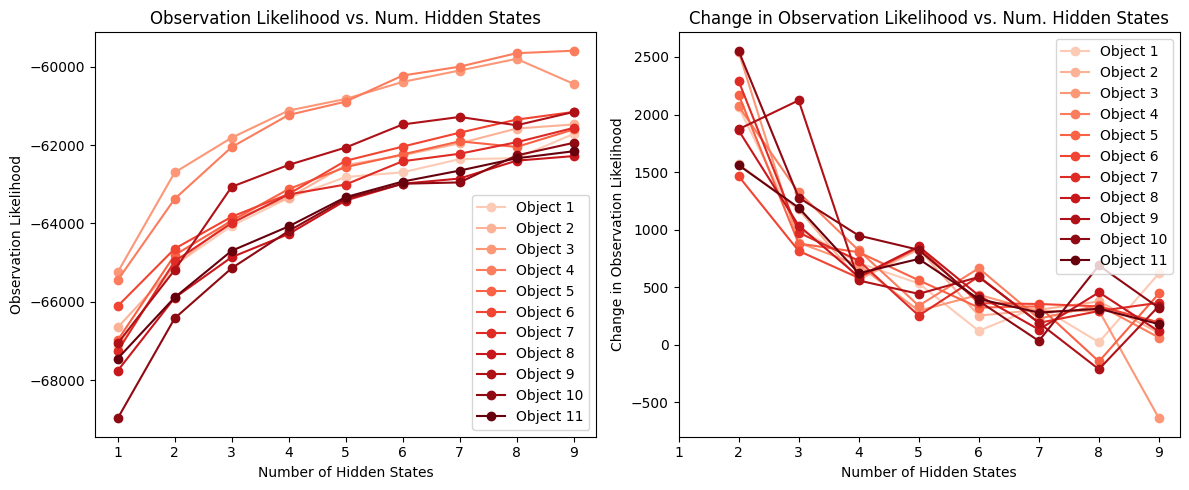

In [291]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].set_title("Observation Likelihood vs. Num. Hidden States")
colormap = plt.colormaps['Reds']
color_offset = 0.2

for object_num in range(0, objects):
    color_value = (object_num / (objects - 1)) * (1 - color_offset) + color_offset
    color = colormap(color_value)

    axes[0].plot(hidden_states_set, scores_all[object_num], "-o", label=f"Object {object_num + 1}", color=color)
    axes[0].set_xticks(hidden_states_set)
    axes[0].set_xlabel("Number of Hidden States")
    axes[0].set_ylabel("Observation Likelihood")

axes[0].legend(loc="lower right")


axes[1].set_title("Change in Observation Likelihood vs. Num. Hidden States")
colormap = plt.colormaps['Reds']
color_offset = 0.2

for object_num in range(0, objects):
    diff = [scores_all[object_num][i] - scores_all[object_num][i-1] for i in range(1, len(hidden_states_set))]

    color_value = (object_num / (objects - 1)) * (1 - color_offset) + color_offset
    color = colormap(color_value)

    axes[1].plot(hidden_states_set[1:], diff, "-o", label=f"Object {object_num + 1}", color=color)
    axes[1].set_xticks(hidden_states_set)
    axes[1].set_xlabel("Number of Hidden States")
    axes[1].set_ylabel("Change in Observation Likelihood")

axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

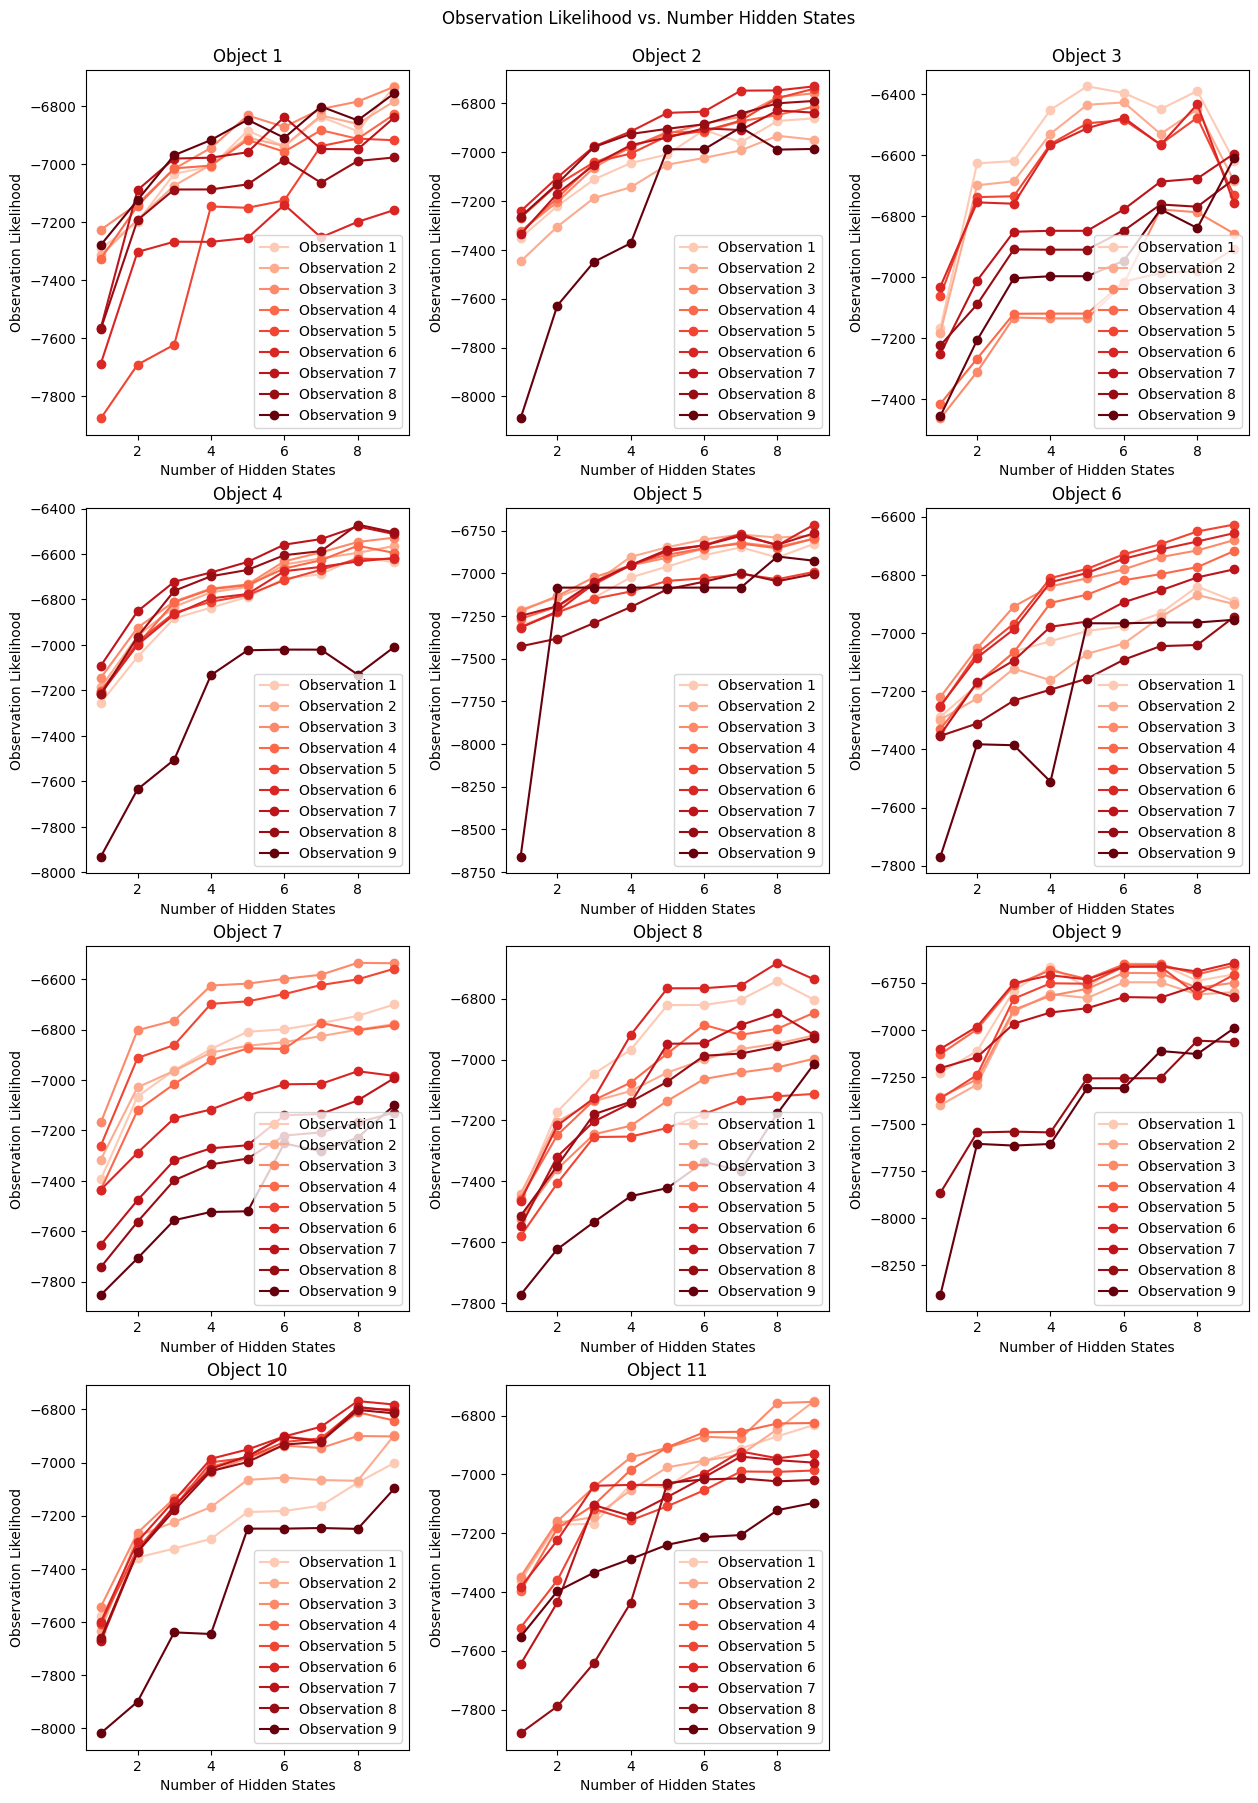

In [293]:
#compute likelihood for seperate observations in training set
#analyze effect of changing the number of hidden states
#model parameters
model_name='GaussianHMM'
cov_type='diag'
n_iter=1000

num_rows = 4
num_cols = 3
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 20))
colormap = plt.colormaps['Reds']
color_offset = 0.2
idx = 0

for object_num in range(0, objects):
    obs_start_idx = 0
    i, j = divmod(idx, num_cols)
    axes[i, j].set_title(f'Object {object_num + 1}')
    for obs_sequence in range(0, run_ideal_max + run_real_max):
        color_value = (obs_sequence / (run_ideal_max + run_real_max - 1)) * (1 - color_offset) + color_offset
        color = colormap(color_value)
        scores = []
        obs_slice = train_data[object_num][obs_start_idx: obs_start_idx + train_lengths[object_num][obs_sequence]]
        obs_start_idx += train_lengths[object_num][obs_sequence]
        for hidden_states in range(0, len(hidden_states_set)):
            trained_model = trained_models_all[object_num][hidden_states]
            curr_score = trained_model.observation_likelihood(obs_slice)
            scores.append(curr_score)
        axes[i, j].plot(hidden_states_set, scores, '-o', label=f'Observation {obs_sequence + 1}', color=color)
    axes[i, j].legend(loc="lower right")
    axes[i, j].set_xlabel("Number of Hidden States")
    axes[i, j].set_ylabel("Observation Likelihood")
    idx += 1

fig.delaxes(axes[-1, -1])
fig.suptitle("Observation Likelihood vs. Number Hidden States")
fig.subplots_adjust(hspace=0.2, top=0.95, wspace=0.3)

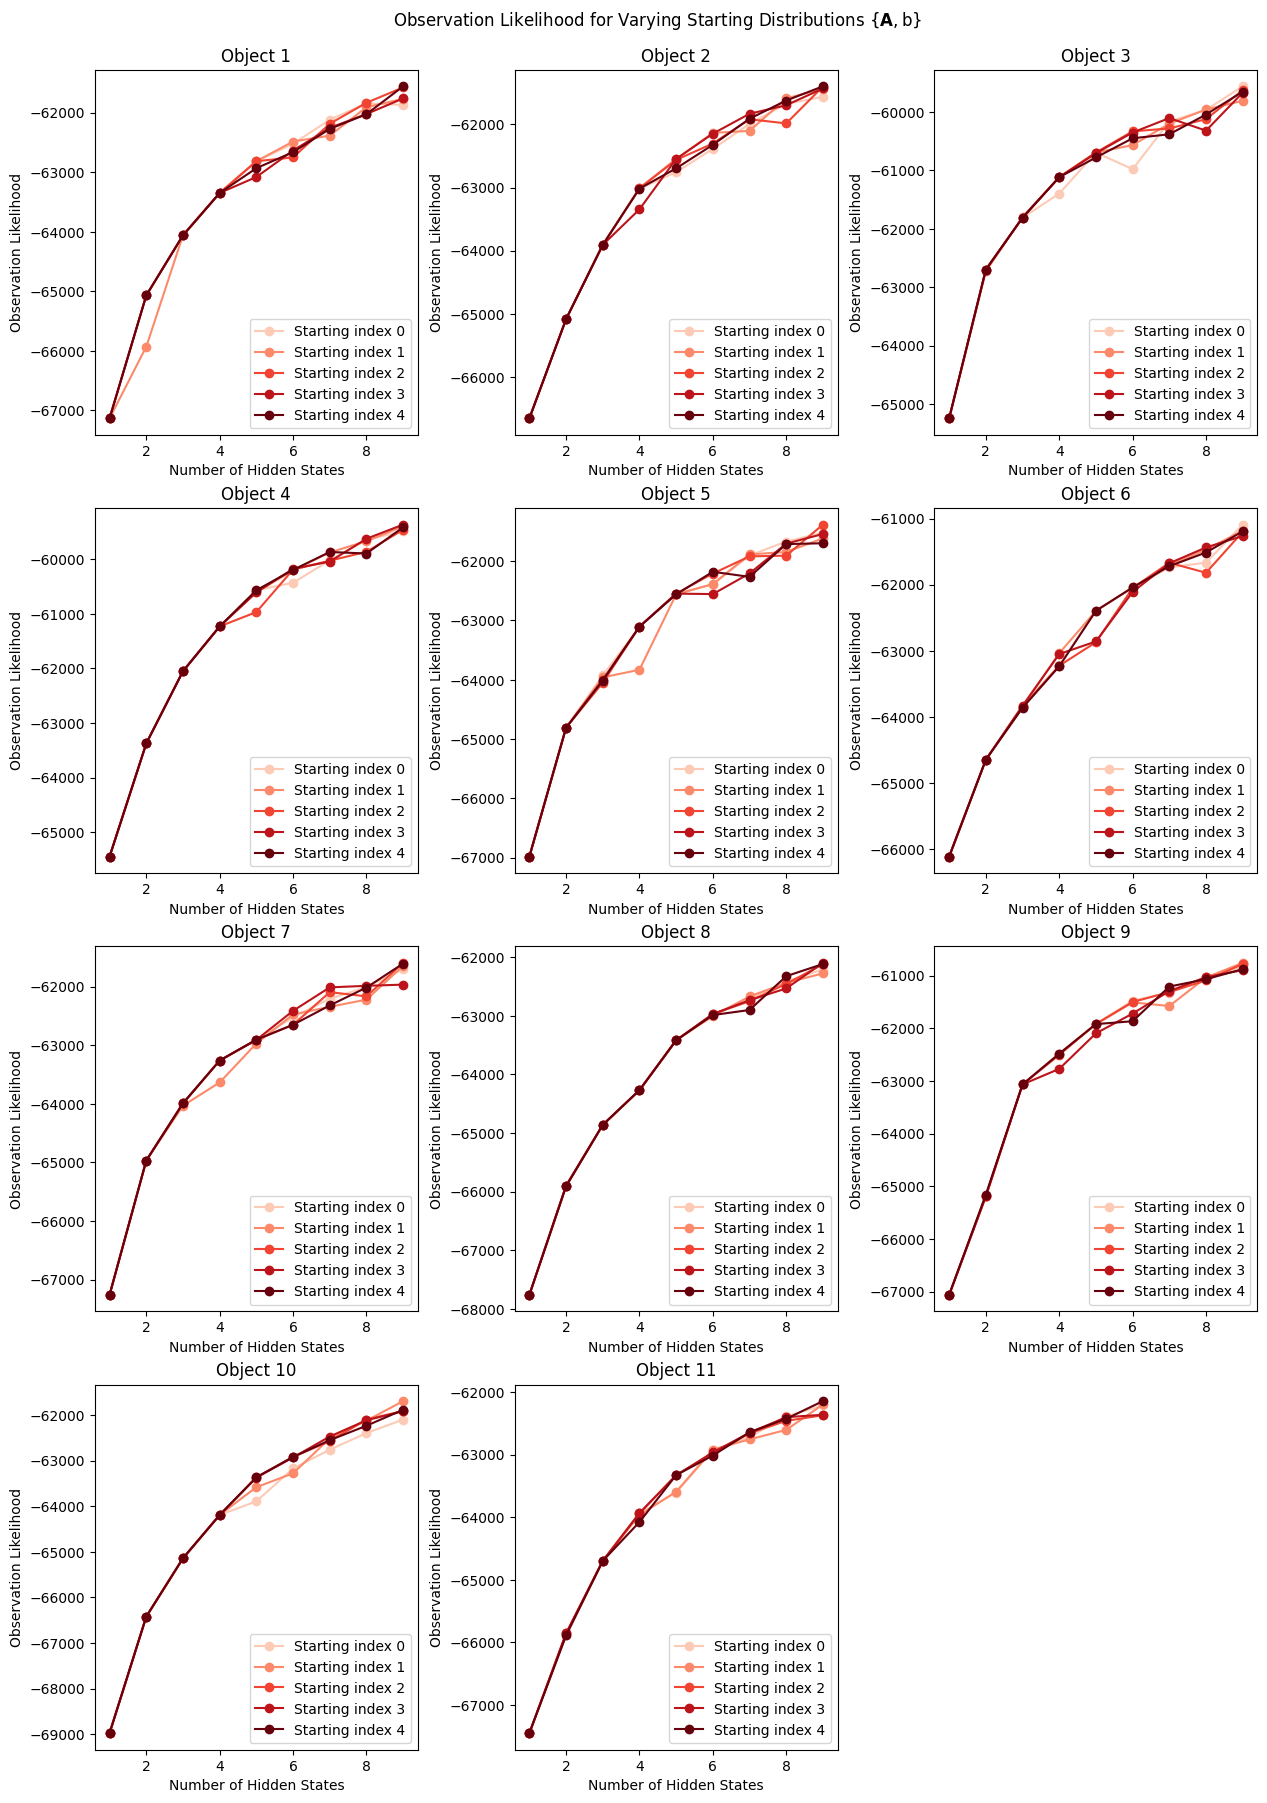

In [294]:
#analyze effect of changing starting A and b matrices
#model parameters
model_name='GaussianHMM'
cov_type='diag'
n_iter=1000
random_starts = 5

num_rows = 4
num_cols = 3
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 20))
colormap = plt.colormaps['Reds']
color_offset = 0.2
idx = 0

for object_num in range(0, objects):
    i, j = divmod(idx, num_cols)
    axes[i, j].set_title(f'Object {object_num + 1}')
    for starting_idx in range(random_starts):
        color_value = (starting_idx / (random_starts - 1)) * (1 - color_offset) + color_offset
        color = colormap(color_value)
        scores = []
        for hidden_states in hidden_states_set:
            trained_model = hmm_generation(model_name=model_name, hidden_states=hidden_states, start_state=starting_idx, cov_type=cov_type, n_iter=n_iter)
            trained_model.train(train_data[object_num], train_lengths[object_num])
            curr_score = trained_model.observation_likelihood(train_data[object_num], lengths=train_lengths[object_num])
            scores.append(curr_score)
            trained_model = None
        axes[i, j].plot(hidden_states_set, scores, '-o', label=f'Starting index {starting_idx}', color=color)
    axes[i, j].legend(loc="lower right")
    axes[i, j].set_xlabel("Number of Hidden States")
    axes[i, j].set_ylabel("Observation Likelihood")
    idx += 1

fig.delaxes(axes[-1, -1])
fig.suptitle("Observation Likelihood for Varying Starting Distributions $\{\mathbf{A}, \mathrm{b}\}$")
fig.subplots_adjust(hspace=0.2, top=0.95, wspace=0.3)

Convergence, Model-GaussianHMM:
Object-1:
Covariance Type diag      : True
Covariance Type spherical : True
Covariance Type full      : True
Covariance Type tied      : True
Object-2:
Covariance Type diag      : True
Covariance Type spherical : True
Covariance Type full      : True
Covariance Type tied      : True
Object-3:
Covariance Type diag      : True
Covariance Type spherical : True
Covariance Type full      : True
Covariance Type tied      : True
Object-4:
Covariance Type diag      : True
Covariance Type spherical : True
Covariance Type full      : True
Covariance Type tied      : True
Object-5:
Covariance Type diag      : True
Covariance Type spherical : True
Covariance Type full      : True
Covariance Type tied      : True
Object-6:
Covariance Type diag      : True
Covariance Type spherical : True
Covariance Type full      : True
Covariance Type tied      : True
Object-7:
Covariance Type diag      : True
Covariance Type spherical : True
Covariance Type full      : True
Covaria

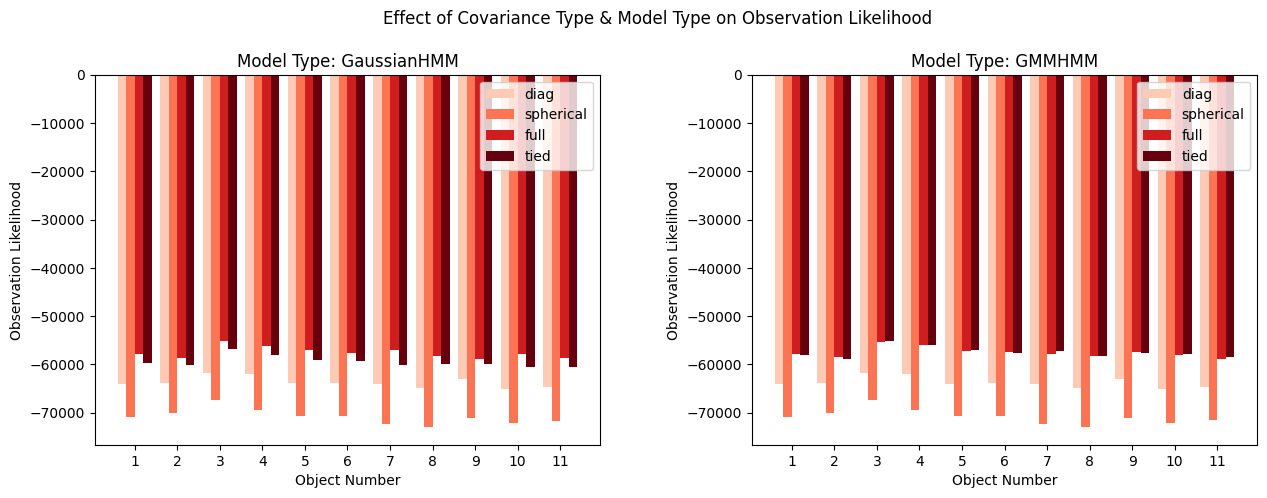

In [311]:
#analyze the effect of changing the model type and the covariance type
model_names=['GaussianHMM', 'GMMHMM']
cov_types=['diag','spherical','full','tied']
hidden_states=3
n_iter=1000

num_rows = 1
num_cols = len(model_names)
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5))
fig.suptitle("Effect of Covariance Type & Model Type on Observation Likelihood")
fig.subplots_adjust(hspace=0.2, top=0.85, wspace=0.3)
colormap = plt.colormaps['Reds']
color_offset = 0.2
width = 0.2

for midx, model_name in enumerate(model_names):
    print(f'Convergence, Model-{model_name}:')
    for object_num in range(0, objects):
        print(f'Object-{object_num + 1}:')
        if model_name in ['GaussianHMM', 'GMMHMM']:
            scores_all = []
            for idx, cov_type in enumerate(cov_types):
                print(f'Covariance Type {cov_type: <10}: ', end="")
                scores = []
                trained_model = hmm_generation(model_name=model_name, hidden_states=hidden_states, cov_type=cov_type, n_iter=n_iter)
                convergence_bool = trained_model.train(train_data[object_num], train_lengths[object_num])
                curr_score = trained_model.observation_likelihood(train_data[object_num], lengths=train_lengths[object_num])
                scores.append(curr_score)
                trained_model = None
                color_value = (idx / (len(cov_types) - 1)) * (1 - color_offset) + color_offset
                color = colormap(color_value)
                scores_all.append(scores)
                if object_num == 0:
                    axes[midx].bar(object_num + width * idx, scores, width=width, color=color, label=cov_type)
                else:
                    axes[midx].bar(object_num + width * idx, scores, width=width, color=color, label='_nolegend_')
                print(f'{convergence_bool}')

            axes[midx].set_xticks([i + width * (len(cov_types) - 1) / 2 for i in range(objects)])
            axes[midx].set_xticklabels([i + 1 for i in range(objects)])
            axes[midx].set_xlabel("Object Number")
            axes[midx].set_ylabel("Observation Likelihood")
            axes[midx].legend(loc="upper right")
            axes[midx].set_title(f'Model Type: {model_name}')

        #elif model_name in ['PoissonHMM', 'MultinomialHMM']:
        #    scores = []
        #    trained_model = hmm_generation(model_name=model_name, hidden_states=hidden_states, n_iter=n_iter)
        #    trained_model.train(train_data[object_num], train_lengths[object_num])
        #    curr_score = trained_model.observation_likelihood(train_data[object_num], lengths=train_lengths[object_num])
        #    scores.append(curr_score)
        #    trained_model = None
        #    color_value = (idx / (len(cov_types) - 1)) * (1 - color_offset) + color_offset
        #    color = colormap(color_value)
        #    axes[midx].bar(object_num + width * idx, scores, width=width, color=color)

    axes[midx].set_xticks([i + width * (len(cov_types) - 1) / 2 for i in range(objects)])
    axes[midx].set_xticklabels([i + 1 for i in range(objects)])
    axes[midx].set_xlabel("Object Number")
    axes[midx].set_ylabel("Observation Likelihood")
    if model_name in ['GaussianHMM', 'GMMHMM']:
        axes[midx].legend(loc="upper right")
    axes[midx].set_title(f'Model Type: {model_name}')

plt.show()

In [316]:
#testing the model on unseen data - first train the model(s) using "optimal" parameters
#model parameters
model_name='GaussianHMM'
cov_type='full'
n_iter=1000
hidden_states_set=[2,3,4,5,6,7]
object_set = [1,2,3,4,5,6,7,8,9,10,11]

trained_models_all = {} #format: [[object_1],[object_2],...,[object_11]] -> object_n = [[hidden_states_1],[hidden_states_2],..,[hidden_states_m]]

for object_num in object_set:
    print(f'Convergence, Object {object_num: <3}: |', end="")
    trained_models_object = {}
    for idx, hidden_states in enumerate(hidden_states_set):
        trained_model = hmm_generation(model_name=model_name, hidden_states=hidden_states, cov_type=cov_type, n_iter=n_iter)
        convergence_bool = trained_model.train(train_data[object_num - 1], train_lengths[object_num - 1])
        trained_model.observation_likelihood(train_data[object_num - 1], lengths=train_lengths[object_num - 1])
        trained_models_object[hidden_states] = trained_model
        trained_model = None
        print(f'{convergence_bool}|', end="")
    print("\n")
    
    trained_models_all[object_num] = trained_models_object

Convergence, Object 1  : |True|True|True|True|True|True|

Convergence, Object 2  : |True|True|True|True|True|True|

Convergence, Object 3  : |True|True|True|True|True|True|

Convergence, Object 4  : |True|True|True|True|True|True|

Convergence, Object 5  : |True|True|True|True|True|True|

Convergence, Object 6  : |True|True|True|True|True|True|

Convergence, Object 7  : |True|True|True|True|True|True|

Convergence, Object 8  : |True|True|True|True|True|True|

Convergence, Object 9  : |True|True|True|True|True|True|

Convergence, Object 10 : |True|True|True|True|True|True|

Convergence, Object 11 : |True|True|True|True|True|True|



In [327]:
#estimate the label of each time-series in the testing dataset
predicted_labels = [] 
real_labels = []
object_set = [1,2,4,5,6,7,9,10]

for hidden_states in hidden_states_set:
    predicted_labels_HS = []
    real_labels_HS = []
    for object_num in object_set:
        obs_start_idx = 0
        for observation_num in range(0, run_ideal_total + run_real_total - run_ideal_max - run_real_max):
            obs_sequence = test_data[object_num - 1][obs_start_idx: obs_start_idx + train_lengths[object_num - 1][observation_num]] #observation sequence
            obs_start_idx += train_lengths[object_num - 1][observation_num]
            for oidx, object_num_sub in enumerate(object_set):
                trained_model = trained_models_all[object_num_sub][hidden_states] #model
                curr_score = trained_model.observation_likelihood(obs_sequence)
                if oidx == 0:
                    highest_score = curr_score
                    highest_likelihood_object = object_num_sub
                elif curr_score > highest_score:
                    highest_score = curr_score
                    highest_likelihood_object = object_num_sub
            real_labels_HS.append(f'Obj. {object_num}')
            predicted_labels_HS.append(f'Obj. {highest_likelihood_object}')
    
    real_labels.append(real_labels_HS)
    predicted_labels.append(predicted_labels_HS)

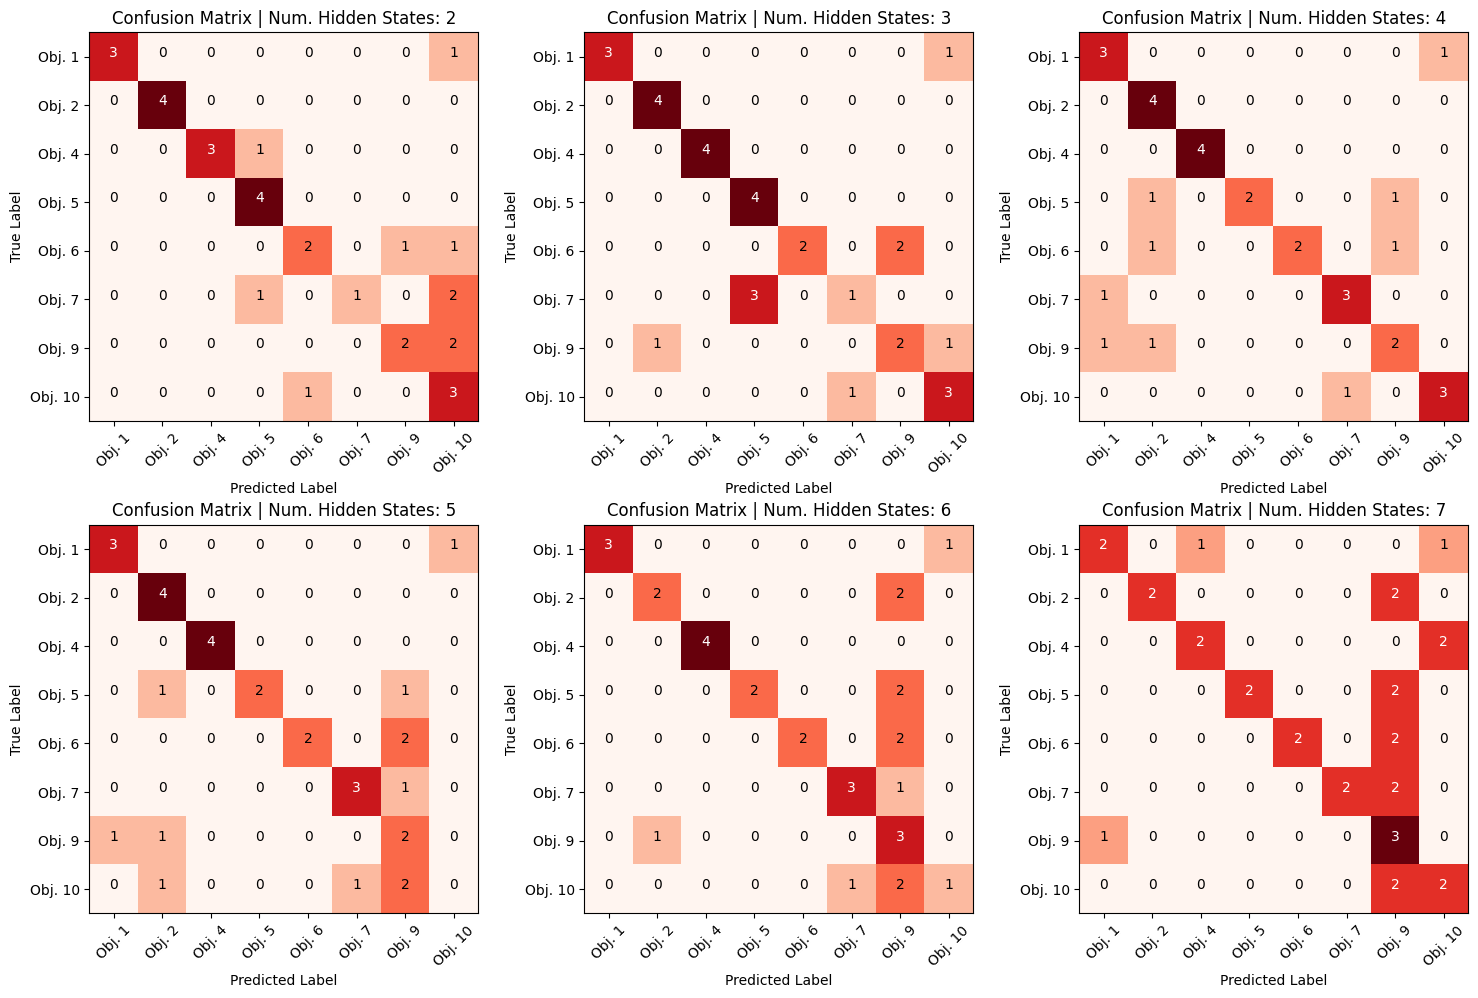

In [328]:
classes = [f'Obj. {i}' for i in object_set]

num_hidden_states = len(hidden_states_set)
num_columns = 3
num_rows = int(np.ceil(num_hidden_states / num_columns))


fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 5*num_rows))


for hsidx, hidden_states in enumerate(hidden_states_set):
    row_idx = hsidx // num_columns
    col_idx = hsidx % num_columns
    cm = confusion_matrix(real_labels[hsidx], predicted_labels[hsidx])
    plot_confusion_matrix(axes[row_idx, col_idx], cm, classes, hidden_states=hidden_states, normalize=False)

if num_hidden_states % num_columns != 0:
    for i in range(num_hidden_states % num_columns, num_columns):
        fig.delaxes(axes[num_rows-1, i])

plt.tight_layout()
plt.show()

In [329]:
#compute performance metrics: accuracy
for hsidx, hidden_states in enumerate(hidden_states_set):
    accuracy = accuracy_score(real_labels[hsidx], predicted_labels[hsidx])
    print(f'Hidden States: {hidden_states} | Accuracy: {accuracy: .2f}')

Hidden States: 2 | Accuracy:  0.69
Hidden States: 3 | Accuracy:  0.72
Hidden States: 4 | Accuracy:  0.72
Hidden States: 5 | Accuracy:  0.62
Hidden States: 6 | Accuracy:  0.62
Hidden States: 7 | Accuracy:  0.53


In [330]:
#compute performance metrics
for hsidx, hidden_states in enumerate(hidden_states_set):
    precision, recall, f1, support = precision_recall_fscore_support(real_labels[hsidx], predicted_labels[hsidx], average='weighted', zero_division=1)
    print(f'Hidden States: {hidden_states: <2} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1-Score: {f1:.2f} | Support: {support}')


Hidden States: 2  | Precision: 0.79 | Recall: 0.69 | F1-Score: 0.69 | Support: None
Hidden States: 3  | Precision: 0.75 | Recall: 0.72 | F1-Score: 0.70 | Support: None
Hidden States: 4  | Precision: 0.77 | Recall: 0.72 | F1-Score: 0.72 | Support: None
Hidden States: 5  | Precision: 0.67 | Recall: 0.62 | F1-Score: 0.74 | Support: None
Hidden States: 6  | Precision: 0.77 | Recall: 0.62 | F1-Score: 0.65 | Support: None
Hidden States: 7  | Precision: 0.75 | Recall: 0.53 | F1-Score: 0.58 | Support: None
